In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import datetime

In [2]:
energy_prod = pd.read_csv('energy_dataset.csv')
weather = pd.read_csv('weather_features.csv')

In [3]:
energy_prod = energy_prod.drop(['forecast wind offshore eday ahead', 
                                'generation hydro pumped storage aggregated',
                               'generation fossil coal-derived gas',
                               'generation fossil oil shale',
                               'generation fossil peat',
                                'generation geothermal',
                               'generation wind offshore',
                               'generation marine'], axis=1)

In [4]:
energy_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

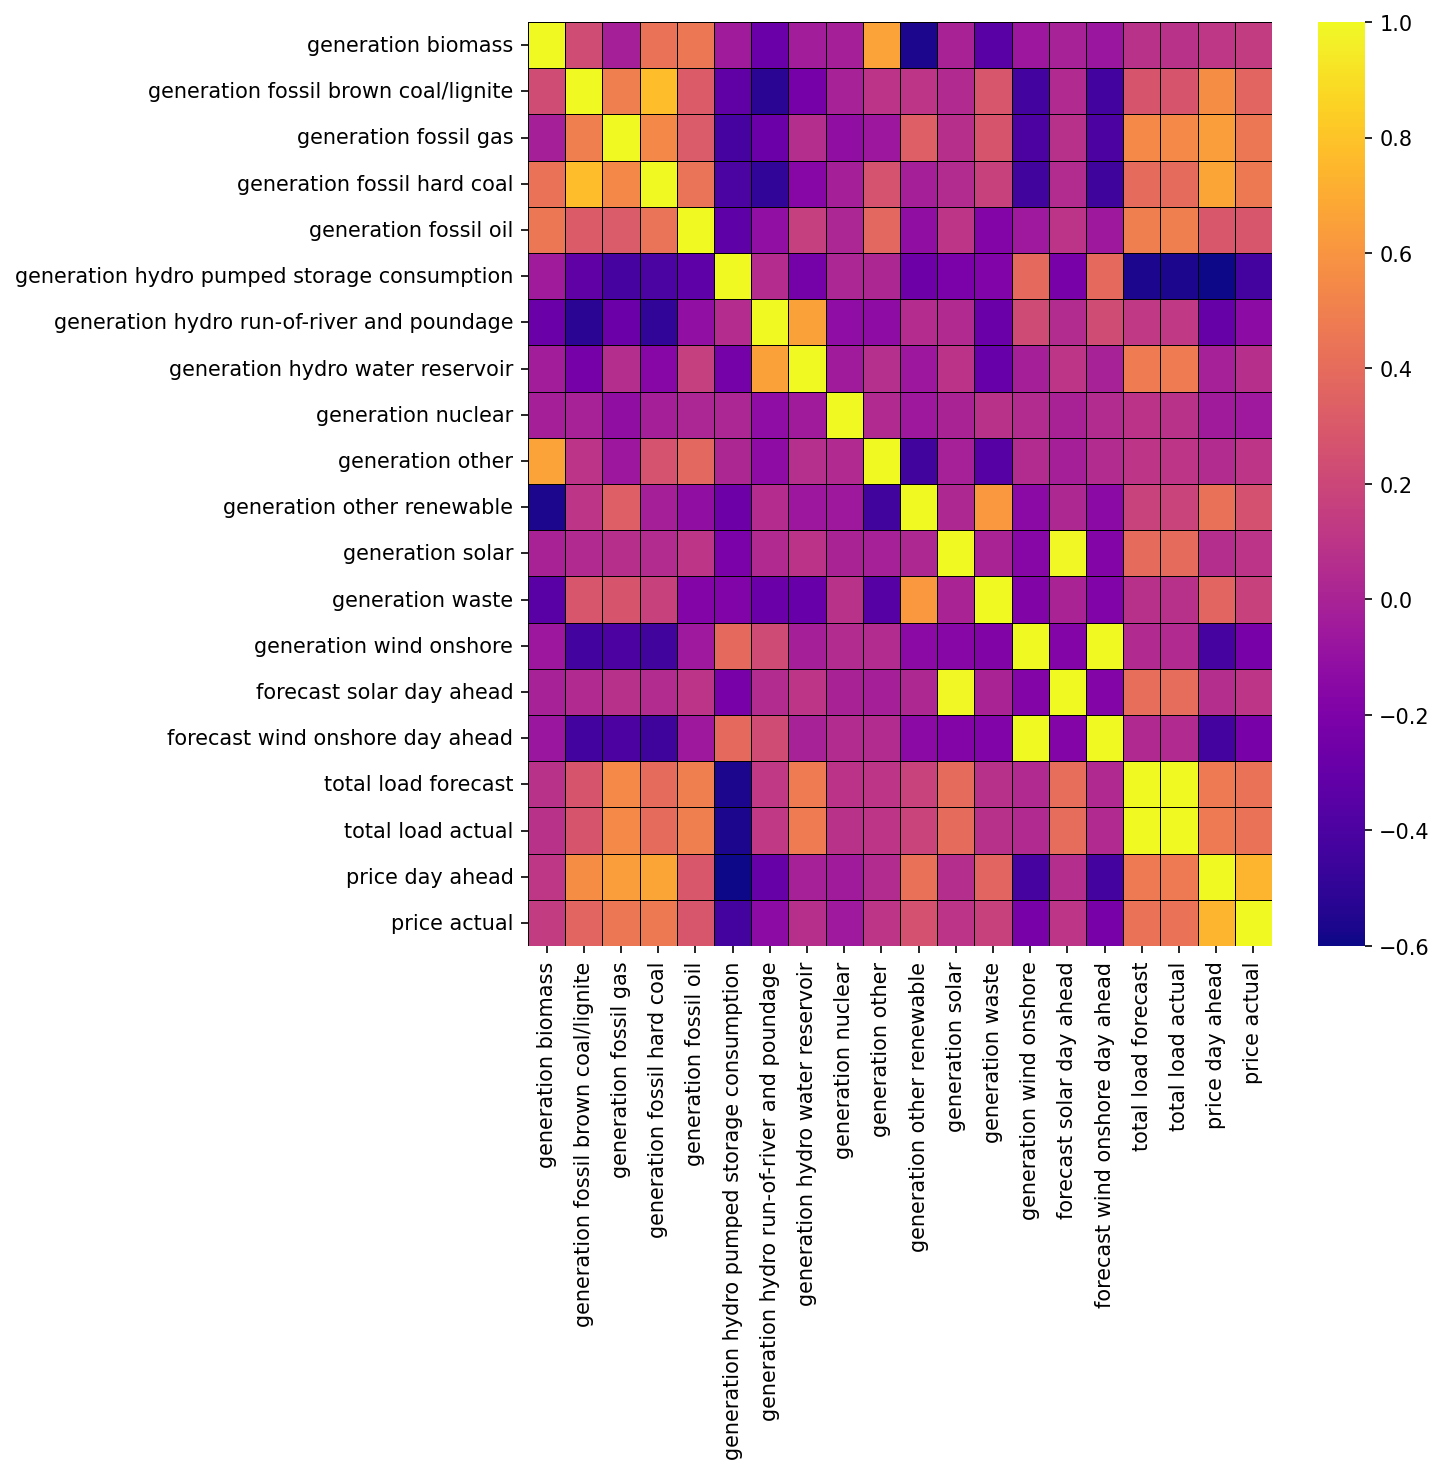

In [9]:
plt.figure(figsize=(8,8), dpi=150)
sns.heatmap(energy_prod.iloc[:, 1:].corr(), cmap="plasma", linewidths=0.3, linecolor="black")
plt.show()

In [10]:
energy_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [11]:
weather['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [12]:
dataset_valencia = weather[weather['city_name'] == "Valencia"]
dataset_madrid = weather[weather['city_name'] == "Madrid"]
dataset_bilbao = weather[weather['city_name'] == "Bilbao"]
dataset_barcelona = weather[weather['city_name'] == "Barcelona"]
dataset_seville = weather[weather['city_name'] == "Seville"]

In [13]:
dataset_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36267 entries, 35145 to 71411
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt_iso               36267 non-null  object 
 1   city_name            36267 non-null  object 
 2   temp                 36267 non-null  float64
 3   temp_min             36267 non-null  float64
 4   temp_max             36267 non-null  float64
 5   pressure             36267 non-null  int64  
 6   humidity             36267 non-null  int64  
 7   wind_speed           36267 non-null  int64  
 8   wind_deg             36267 non-null  int64  
 9   rain_1h              36267 non-null  float64
 10  rain_3h              36267 non-null  float64
 11  snow_3h              36267 non-null  float64
 12  clouds_all           36267 non-null  int64  
 13  weather_id           36267 non-null  int64  
 14  weather_main         36267 non-null  object 
 15  weather_description  36267 non-null  

In [14]:
dataset_madrid["time"] = dataset_madrid["dt_iso"]

/var/folders/yk/ss7gnth141s6qj3jlxwlyyqw0000gn/T/ipykernel_6877/3144446381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_madrid["time"] = dataset_madrid["dt_iso"]


In [17]:
df_merged = pd.merge(energy_prod, dataset_madrid, on='time', how='inner')

In [18]:
df_fin = df_merged.drop(['dt_iso','city_name'], axis=1)

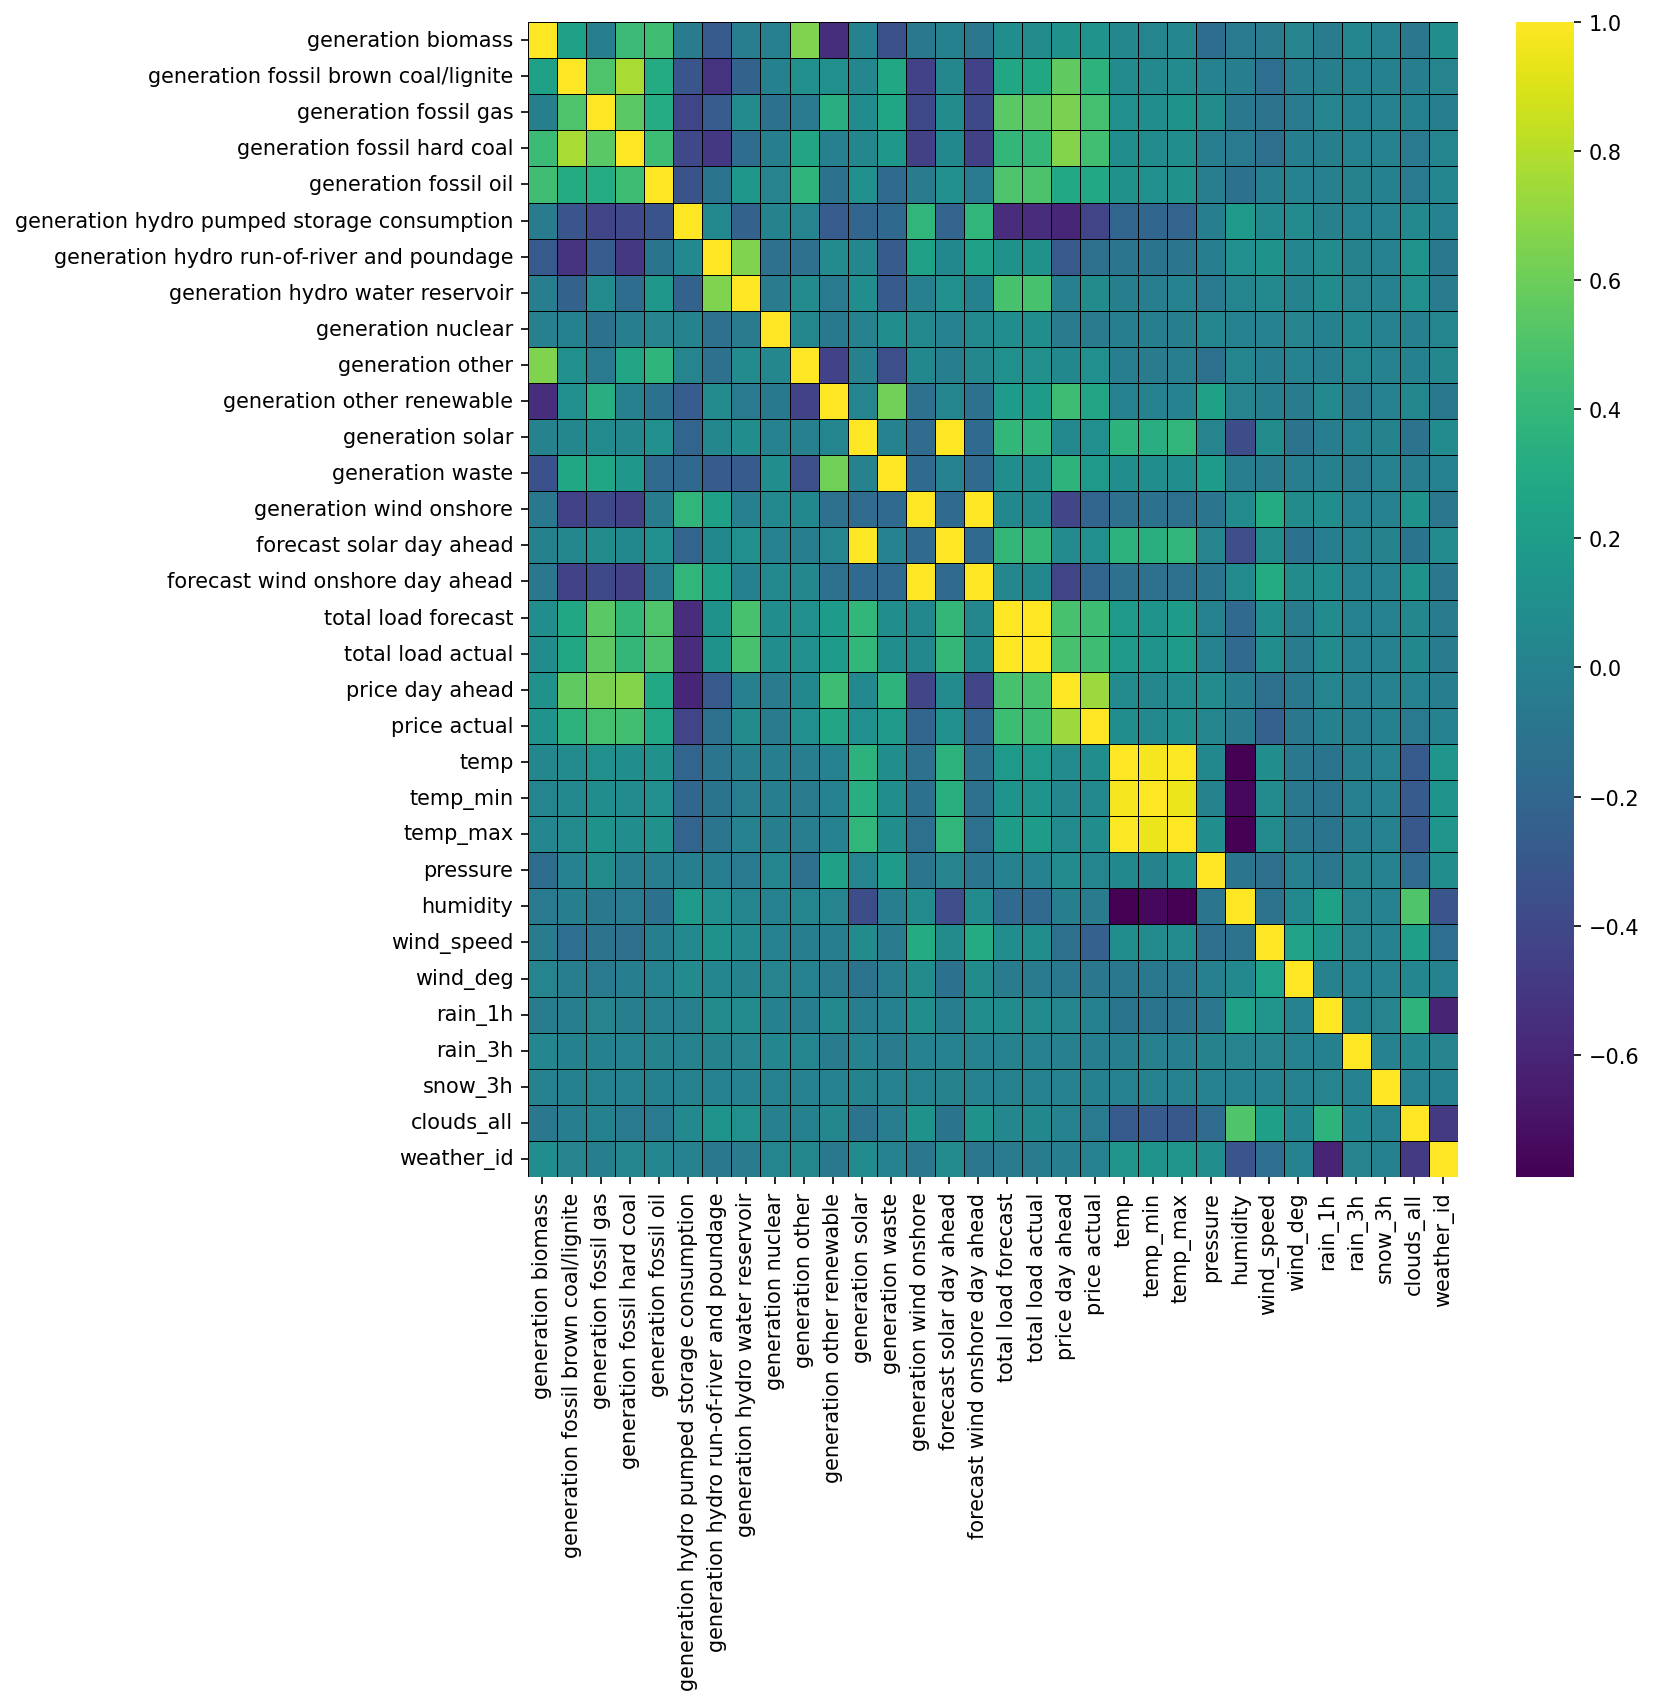

In [20]:
plt.figure(figsize=(10,10), dpi=150)
sns.heatmap(df_fin.iloc[:,1:33].corr(), cmap="viridis", linewidth = 0.4,linecolor="black")
plt.show()

In [21]:
df_fin['time'] = pd.to_datetime(df_fin['time'], utc=True)

In [22]:
db_fin = df_fin.set_index('time')

In [23]:
db_fin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36267 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 35 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           36248 non-null  float64
 1   generation fossil brown coal/lignite         36249 non-null  float64
 2   generation fossil gas                        36249 non-null  float64
 3   generation fossil hard coal                  36249 non-null  float64
 4   generation fossil oil                        36248 non-null  float64
 5   generation hydro pumped storage consumption  36248 non-null  float64
 6   generation hydro run-of-river and poundage   36248 non-null  float64
 7   generation hydro water reservoir             36249 non-null  float64
 8   generation nuclear                           36250 non-null  float64
 9   generation other         

In [25]:
df = db_fin.copy()

In [26]:
df = db_fin.drop(["price day ahead", "forecast wind onshore day ahead", 
                  "forecast solar day ahead", "total load forecast", 
                  "weather_main", "weather_description", "weather_icon"], axis = 1)

In [29]:
df2 = df.dropna() 

In [30]:
y = df2["price actual"]

In [31]:
X = df2.drop(['price actual'], axis = 1)

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [34]:
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000, learning_rate=0.05, max_depth = 6)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [35]:
y_pred = xgb_reg.predict(X_test)

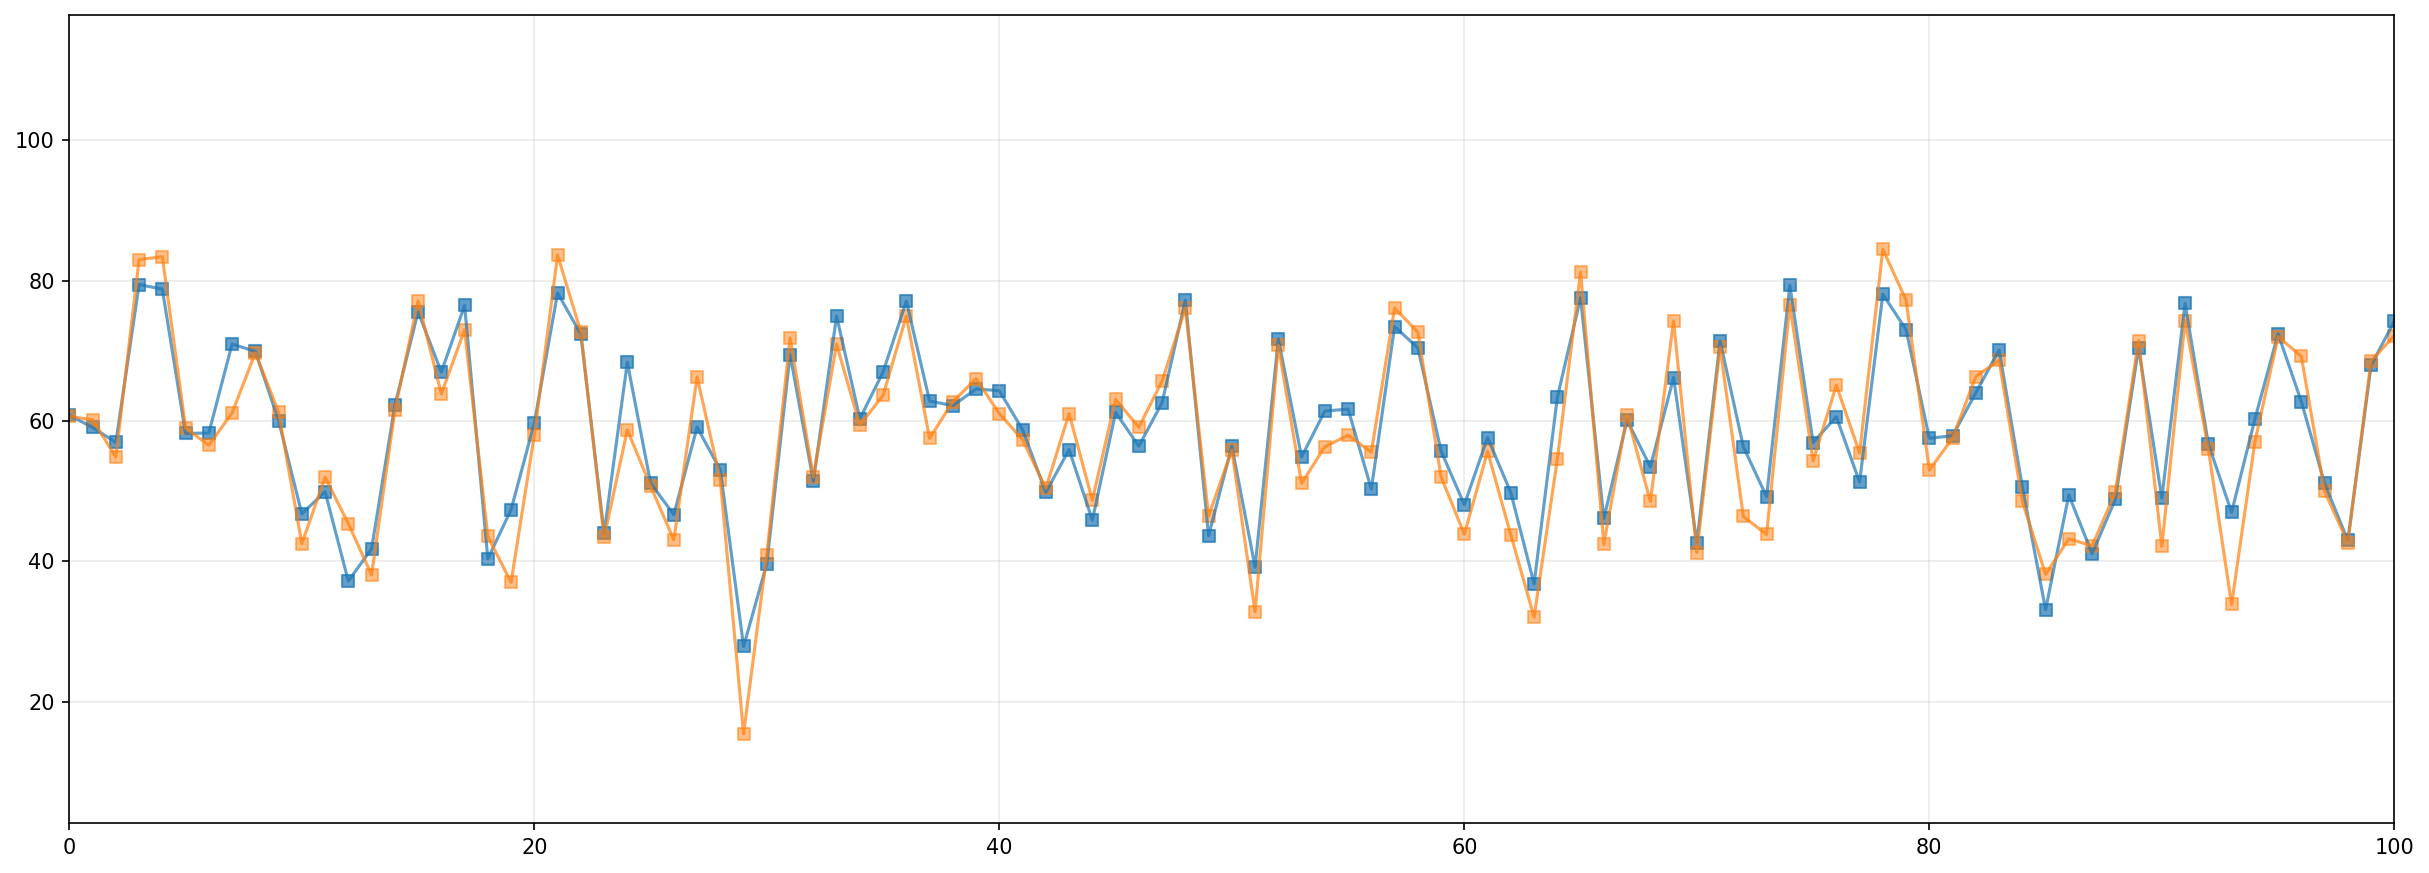

In [36]:
x = np.arange(0, len(y_test), 1)


plt.figure(figsize=(20,7), dpi=150)
plt.scatter(x, y_pred, marker = "s", alpha=0.7)
plt.plot(y_pred,alpha=0.7)
plt.scatter(x, y_test.values, marker="s", alpha=0.5)
plt.plot(y_test.values, alpha=0.7)
plt.grid(True, linewidth=0.2)
plt.xlim([0,100])
plt.show()

In [37]:
mse = mean_squared_error(y_pred,y_test)

In [38]:
print(f"MSE XGB: {mse:.3f}")

MSE XGB: 23.818


In [39]:
from sklearn.ensemble import GradientBoostingRegressor

In [40]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [41]:
y_pred_gbr = gbr.predict(X_test)

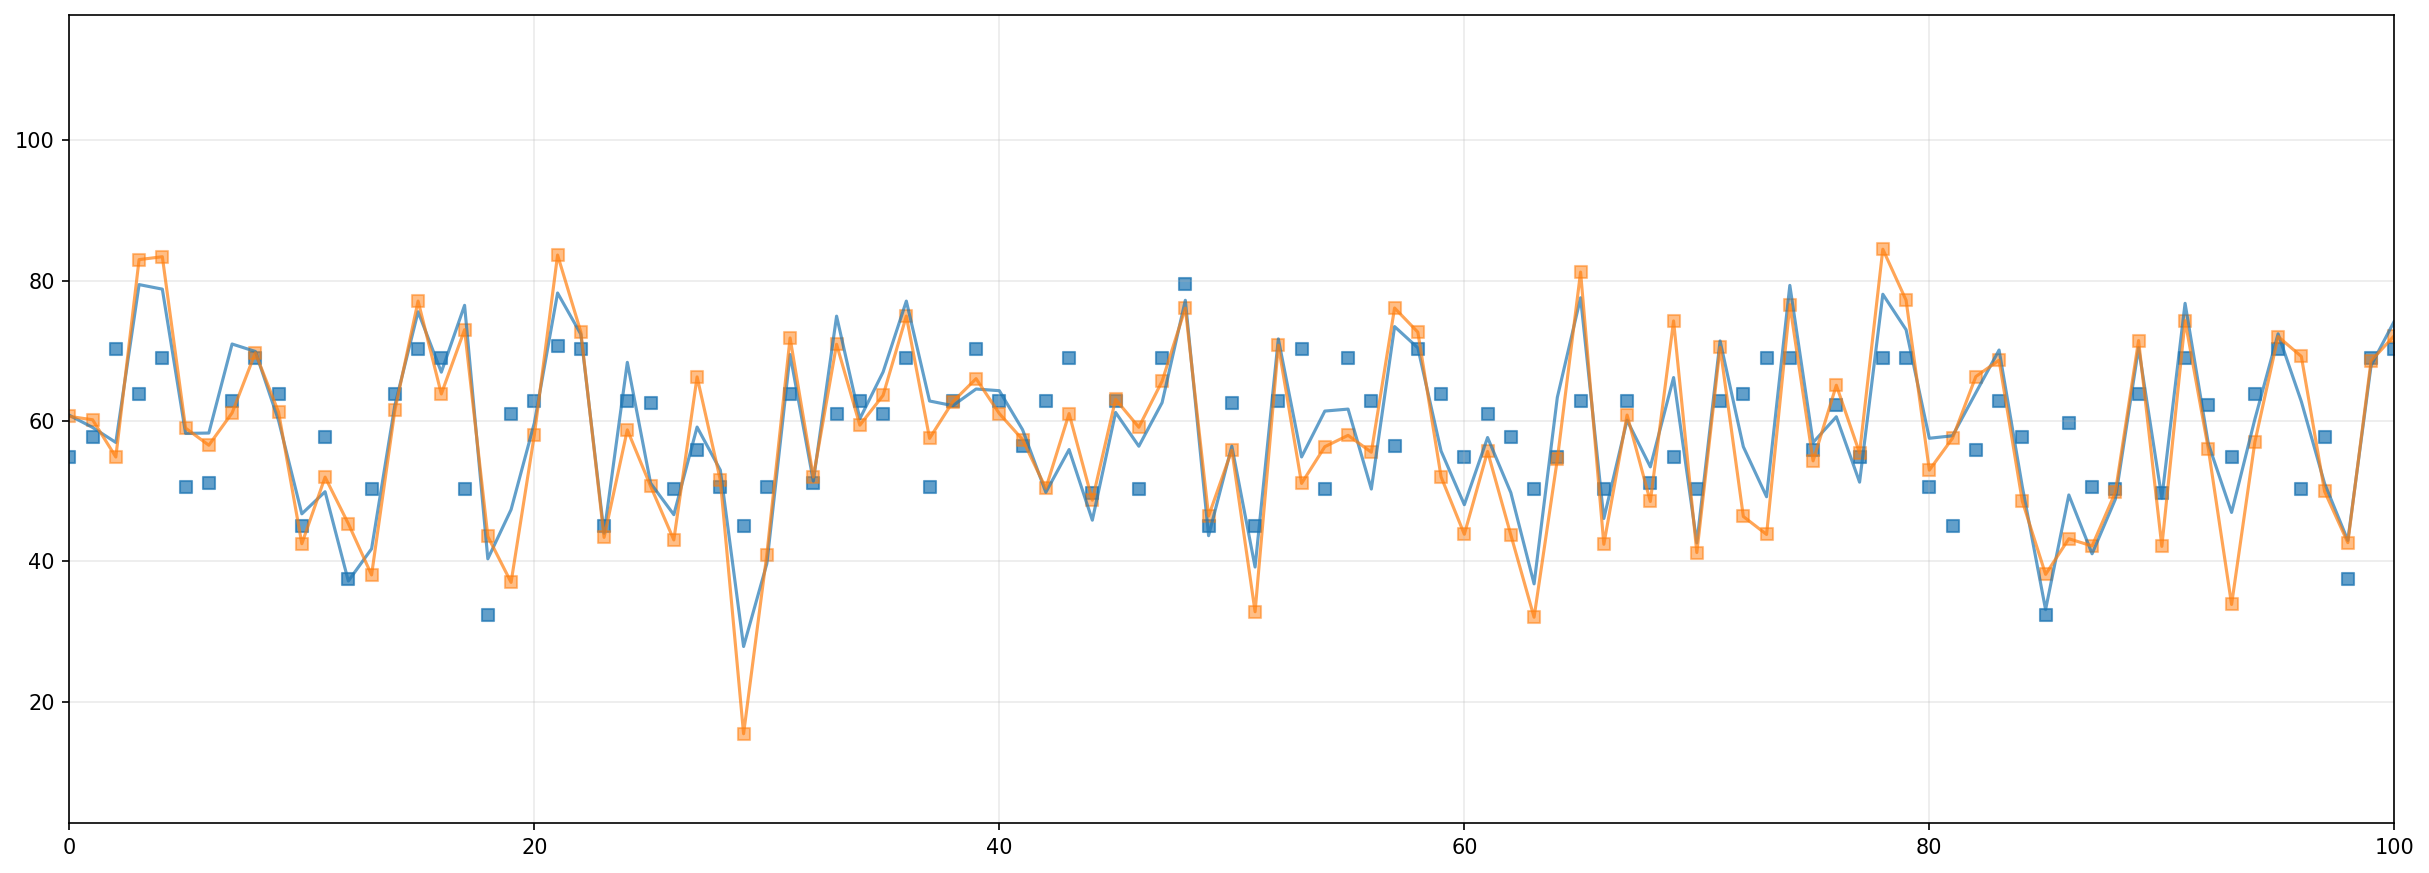

In [42]:
x = np.arange(0, len(y_test), 1)


plt.figure(figsize=(20,7), dpi=150)
plt.scatter(x,y_pred_gbr, marker = "s", alpha=0.7)
plt.plot(y_pred,alpha=0.7)
plt.scatter(x, y_test.values, marker="s", alpha=0.5)
plt.plot(y_test.values, alpha=0.7)
plt.grid(True, linewidth=0.2)
plt.xlim([0,100])
plt.show()

In [43]:
mse_gbr = mean_squared_error(y_pred_gbr, y_test)

In [44]:
print(f"MSE GBR: {mse_gbr:.3f}")

MSE GBR: 129.564


## Ridge

In [45]:
from sklearn.linear_model import Ridge

In [57]:
ridge_reg = Ridge(alpha=0.01, solver="cholesky")
ridge_reg.fit(X_train, y_train)

Ridge(alpha=0.01, solver='cholesky')

In [58]:
y_pred_ridge = ridge_reg.predict(X_test)

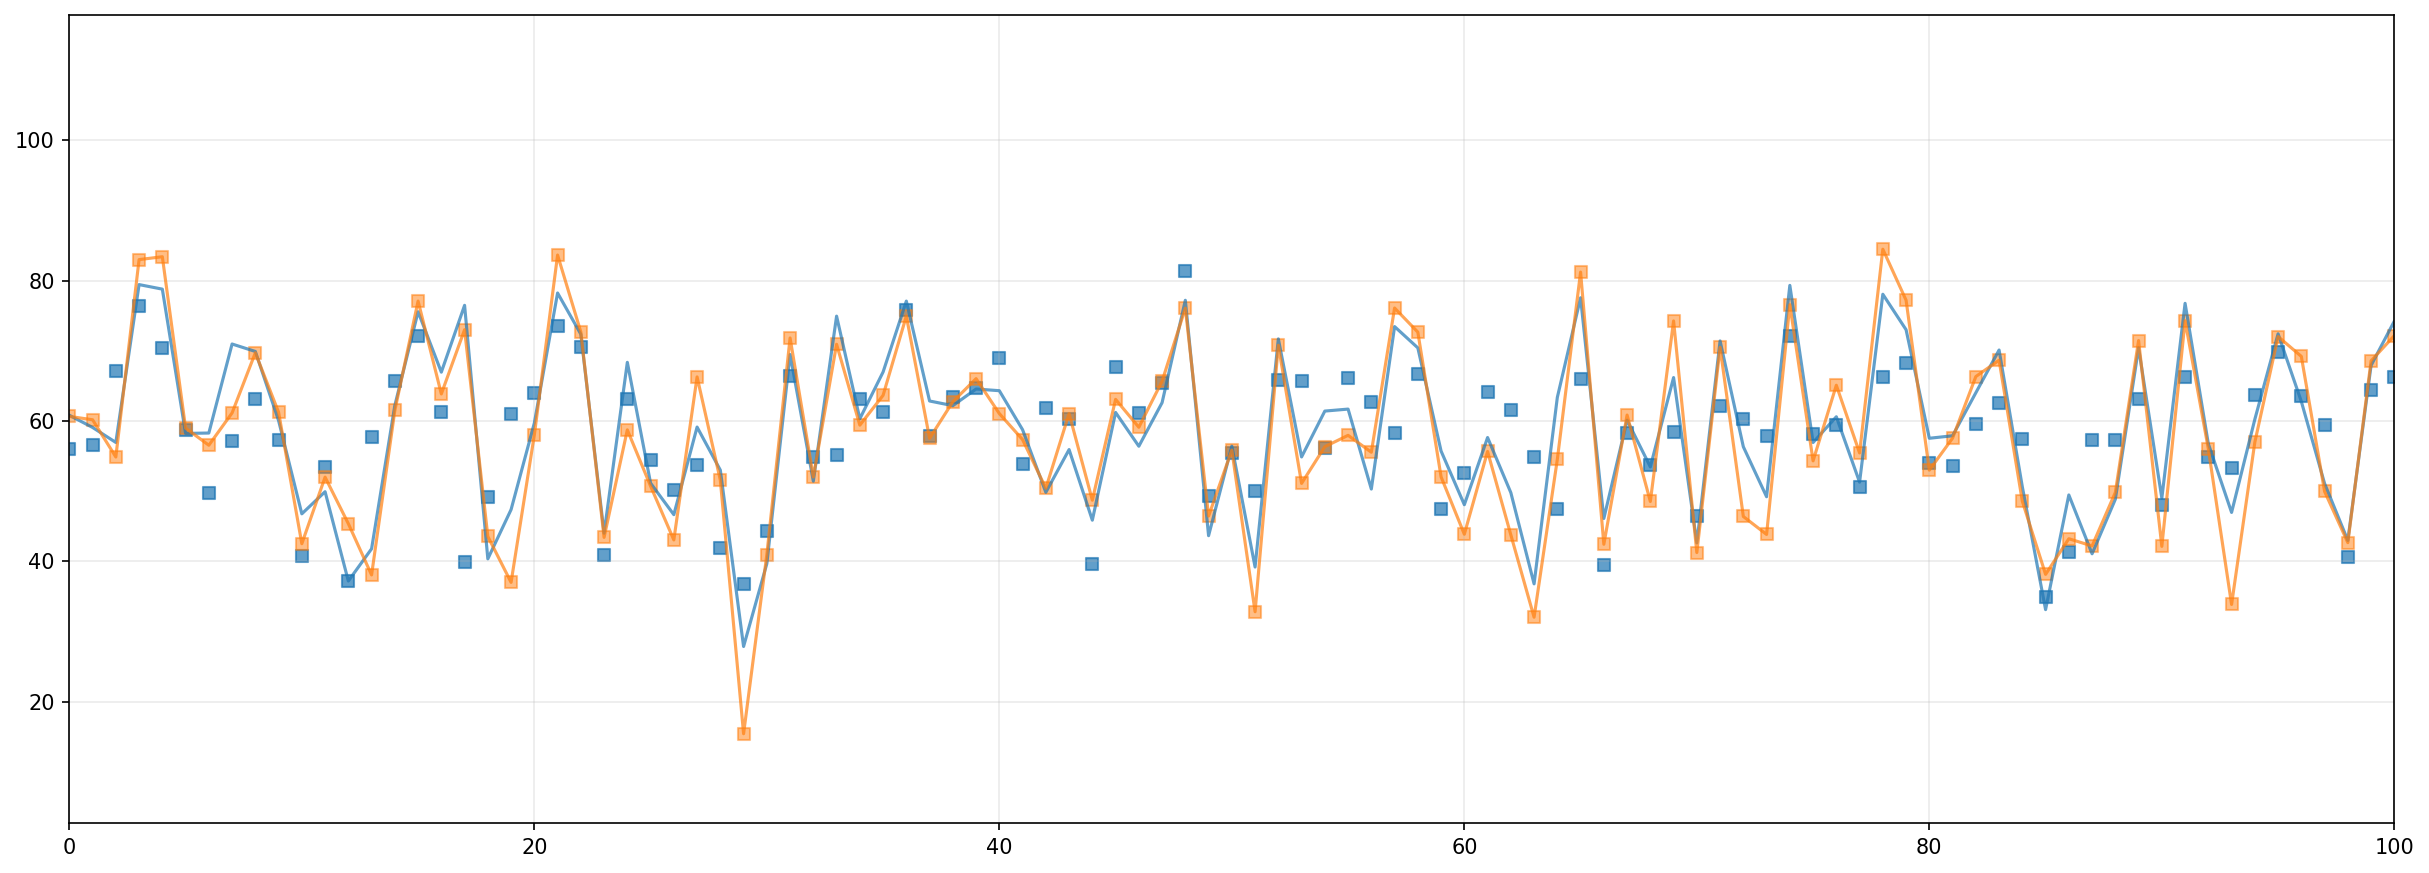

In [59]:
x = np.arange(0, len(y_test), 1)


plt.figure(figsize=(20,7), dpi=150)
plt.scatter(x,y_pred_ridge, marker = "s", alpha=0.7)
plt.plot(y_pred,alpha=0.7)
plt.scatter(x, y_test.values, marker="s", alpha=0.5)
plt.plot(y_test.values, alpha=0.7)
plt.grid(True, linewidth=0.2)
plt.xlim([0,100])
plt.show()

In [60]:
mse_ridge = mean_squared_error(y_pred_ridge, y_test)

In [61]:
print(f"MSE RIDGE: {mse_ridge:.3f}")

MSE RIDGE: 116.351


## RIDGE with grid search

In [62]:
alphas = np.arange(0,1,0.01)

In [63]:
mse = []

for alpha in alphas:
    model  = Ridge(alpha = alpha, solver='cholesky')
    model.fit(X_train,y_train)
    y_pred_ridge_gs = model.predict(X_test)
    mse_ridge_gs = mean_squared_error(y_pred_ridge_gs, y_test)
    mse.append((mse_ridge_gs, alpha))
    

In [64]:
min(mse) ##riscrivo la sopra 

(116.35075017771798, 0.01)

In [65]:
df2["price actual"]

time
2014-12-31 23:00:00+00:00    65.41
2015-01-01 00:00:00+00:00    64.92
2015-01-01 01:00:00+00:00    64.48
2015-01-01 02:00:00+00:00    59.32
2015-01-01 03:00:00+00:00    56.04
                             ...  
2018-12-31 18:00:00+00:00    77.02
2018-12-31 19:00:00+00:00    76.16
2018-12-31 20:00:00+00:00    74.30
2018-12-31 21:00:00+00:00    69.89
2018-12-31 22:00:00+00:00    69.88
Name: price actual, Length: 36221, dtype: float64

In [66]:
df2["day"] = df2.index.day
df2["month"] = df2.index.month

/var/folders/yk/ss7gnth141s6qj3jlxwlyyqw0000gn/T/ipykernel_6877/4163971758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["day"] = df2.index.day
/var/folders/yk/ss7gnth141s6qj3jlxwlyyqw0000gn/T/ipykernel_6877/4163971758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["month"] = df2.index.month


In [67]:
split = 0.7
train = df2[:int(len(df2)*split)]
test = df2[int(len(df2)*split):]

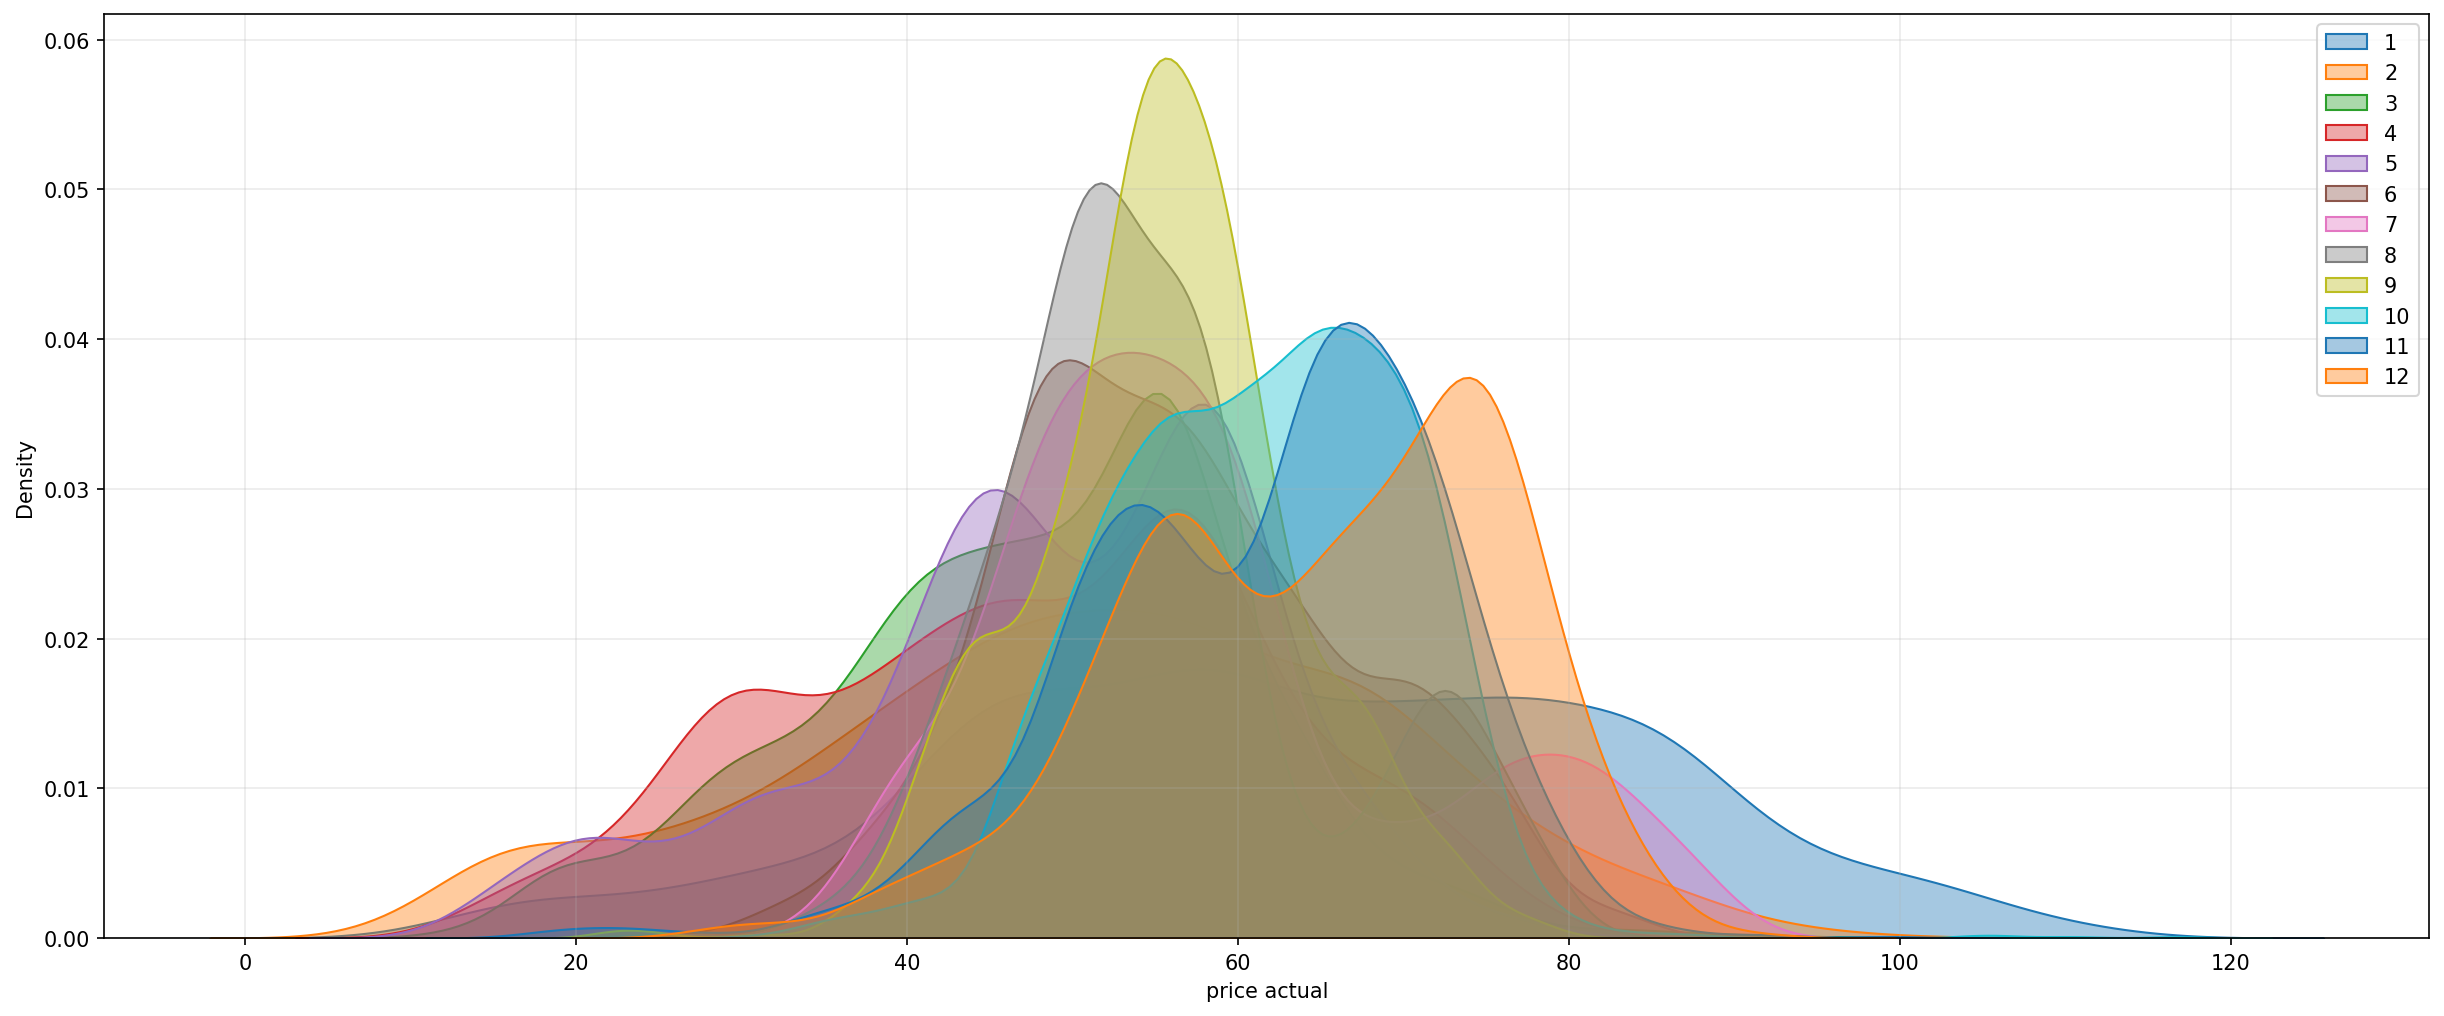

In [69]:
days = [0,1,2,3,4,5,6]
months = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.figure(figsize=(20,8), dpi=150)

for month in months:
    dataset_day = train[train["month"] == month]
    sns.kdeplot(data=dataset_day["price actual"],fill=True, label=month, alpha=0.4)
    #print(dataset_day["price actual"].describe())
    
    
plt.grid(True, linewidth=0.2)
plt.legend()
plt.show()